| | |
|--|--|
| **Names** | *Jan Thiemen Postema & Robert Maaskant* |
| **Group** | *32* |

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import operator
import pylab
import math

pylab.rcParams['figure.figsize'] = (10.0, 8.0)


# Bayesian Decision Theory

In this lab, we will create generative models of data. The data that we will use is the same as in the lab on logistic regression, and we will create a model where we use 2-dimensional Gaussian distributions to describe the data in each class. We then use Bayes' rule to compute the probability of a datapoint belonging to a certain class.

The code below loads the data and provides you with an effective, simple to understand and simple to use implementation of the Gaussian PDF. 

So, first, let's load the data.

In [2]:
# This code is given

data = np.load("lab-7.npz")
d = data['d']
l = data['l'].ravel()

colours = [ [ 'b', 'r' ][int(x)] for x in np.nditer(l)]
#plt.scatter(d[:,0],d[:,1],20,colours)

In [3]:
# Our own implementation of the multivariate Gaussian Distribution
class Gauss:
    def __init__(self, mu, sigma):
        """Initialise a distribution with mean mu and covariance sigma
        
        Precompute and store everything that is not dependent
        on the datapont, so as to keep things efficient"""
        D = mu.size
        
        self.mu = mu
        self.icov = np.linalg.inv(sigma)
        sign,ld = np.linalg.slogdet(sigma)
        if sign != 1:
            print "Sign=",sign
        
        self.lognum = D*np.log(2*np.pi) + ld
                            
    def logprob(self,x):
        """return log(p(x))"""
        d = x-self.mu
        return .5 * (self.lognum - np.dot(np.dot(d,self.icov),d))
    
    def prob(self,x):
        """return p(x)"""
        return np.exp(self.logprob(x)) 


# Code for plotting the heat map
import time
from IPython import display

xx,yy = np.mgrid[-5:10:.1,-5:10:.1]
def plotHeat(f):
    """ Plot a heatmap for an arbitrary function"""
    display.clear_output(wait=True)
    display.display(plt.gcf())
    p = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            p[i,j] = f(xx[i,j], yy[i,j])
    plt.pcolor(xx,yy,p,cmap='seismic')
    plt.xlim([-5,10])
    plt.ylim([-5,10])
    plt.scatter(d[:,0],d[:,1],20,colours)
    z1 = plt.mlab.bivariate_normal(xx, yy, cov_1[0,0], cov_1[1,1], mu_1[0], mu_1[1], cov_1[0,1])
    z2 = plt.mlab.bivariate_normal(xx, yy, cov_2[0,0], cov_2[1,1], mu_2[0], mu_2[1], cov_2[0,1])
    plt.contour(xx,yy, z1)
    plt.contour(xx,yy, z2)
    plt.show()
    time.sleep(.01)
    
def nn(x,y):
    mindist = 1e200
    bestl = 0
    for p,t in zip(d, l):
        dist = (p[0]-x)**2+(p[1]-y)**2
        if dist<mindist:
            mindist = dist
            bestl = t
    return bestl

## Unconstrained model

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\c}{\mathcal{C}}
\newcommand{\mean}{\boldsymbol{\mu}}
\newcommand{\cov}{\boldsymbol{\Sigma}}
$$

In this first exercise, we will create two normal distributions, one for each class. The probability density at a datapoint, given that it belongs to class one, is given by:
$$
p(\x|\c_1) = \frac{1}{\sqrt{(2\pi)^k |\cov_1|}} \exp-\frac12 (\x-\mean_1)^\top \cov_1^{-1} (\x-\mean_1)
$$
where $k$ is the dimensionality of the data (in this case, 2), $\mean_1$ is the mean of the data and $\cov_1$ is the covariance of the data. The probability density for a datapoint belonging to class two is given analogously, with its own parameters $\mean_2$ and $\cov_2$.

**Question 1 [5 credits]**
Split your dataset into 80\% training set and 20% test set. Using the train set, learn the two Gaussian distributions for the two classes. That is, implement a function to compute the sufficient statistics for the class-conditional distributions yourself. 

In [4]:
d_train = d[:int(len(d)*0.8)]
d_test = d[int(len(d)*0.8):]
l_train = l[:int(len(d)*0.8)]
l_test = l[int(len(d)*0.8):]

[[ 1.02516768  0.90590366]
 [ 0.90590366  1.95137212]]
[ 0.04354087  0.06044872]


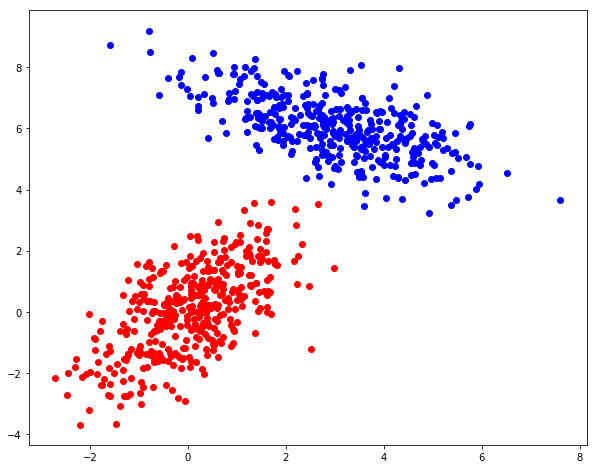

In [5]:
# Answer to Q1
classes = {0: [], 1: []}
for point, label in zip(d_train,l_train):
    classes[label].append(point)


plt.scatter(*zip(*classes[0]), color='red')
plt.scatter(*zip(*classes[1]), color='blue')

mu_1 = np.mean(classes[0], axis=0)
cov_1 = np.cov(classes[0], rowvar=0)
print cov_1

mu_2 = np.mean(classes[1], axis=0)
cov_2 = np.cov(classes[1], rowvar=0)

print mu_1

In [6]:
from math import sqrt, pi, exp

def p_x_c(mu, cov, x):
    xdist = x-mu
    xdist = xdist.T
    #print "inv", np.linalg.inv(cov)
    #print "trans", np.transpose(xdist)
    c = np.dot(np.dot(np.transpose(xdist), np.linalg.inv(cov)), xdist)
    #print "C", c
    #print "det", np.linalg.det(cov)
    return (1/(np.sqrt((2*pi)**2 * np.linalg.det(cov)))) * exp(-(1/2))*c

correct = 0
wrong = 0

for x, label in zip(d_test,l_test):
    print "------------"
    print label
    #print "X", x
    p_c1 = p_x_c(mu_1, cov_1, [x])
    p_c2 = p_x_c(mu_2, cov_2, [x])
    #print "P(x|c1) = ", p_c1
    #print "P(x|c2) = ", p_c2
    
    pred = (p_c1 * 0.5) / (p_c1 *0.5 + p_c2 *0.5)
    print pred
    pred = (p_c2 * 0.5) / (p_c1 *0.5 + p_c2 *0.5)
    print pred

    if pred > 0.5:
        if label == 1.0:
            correct = correct + 1
        else:
            wrong = wrong + 1
    else:
        if label == 0.0:
            correct = correct + 1
        else:
            wrong = wrong + 1

print wrong
print correct

------------
0.0
[[ 0.06434671]]
[[ 0.93565329]]
------------
1.0
[[ 0.89482727]]
[[ 0.10517273]]
------------
0.0
[[ 0.08447744]]
[[ 0.91552256]]
------------
1.0
[[ 0.90775472]]
[[ 0.09224528]]
------------
1.0
[[ 0.94968522]]
[[ 0.05031478]]
------------
1.0
[[ 0.81392462]]
[[ 0.18607538]]
------------
0.0
[[ 0.00023902]]
[[ 0.99976098]]
------------
0.0
[[ 0.00158716]]
[[ 0.99841284]]
------------
1.0
[[ 0.56320907]]
[[ 0.43679093]]
------------
1.0
[[ 0.93074867]]
[[ 0.06925133]]
------------
1.0
[[ 0.95706709]]
[[ 0.04293291]]
------------
0.0
[[ 0.01893036]]
[[ 0.98106964]]
------------
1.0
[[ 0.97026828]]
[[ 0.02973172]]
------------
1.0
[[ 0.93994316]]
[[ 0.06005684]]
------------
1.0
[[ 0.9210764]]
[[ 0.0789236]]
------------
1.0
[[ 0.91378486]]
[[ 0.08621514]]
------------
0.0
[[ 0.01055122]]
[[ 0.98944878]]
------------
0.0
[[ 0.00597698]]
[[ 0.99402302]]
------------
0.0
[[ 0.01814516]]
[[ 0.98185484]]
------------
1.0
[[ 0.9503854]]
[[ 0.0496146]]
------------
0.0
[[ 0.01

**Question 2 [5 credits]**
Write down Bayes' rule to compute $p(\c_1|\x)$, and implement it. Plot the discriminant using the code provided. What is the performance of the model on the test set?

$$
p(\c_1|\x) = \frac{p(\x|\c_1) * p(\c_1)}{p(\x|\c_1) + p(\x|\c_2)}
$$

In [7]:
# Answer to q2

def posterior(x,y):
    p_c1 = len(classes[0]) / (len(classes[0]) + len(classes[1]) + 1.0)
    p_x_c1 = p_x_c(mu_1, cov_1, [x,y])
    p_x_c2 = p_x_c(mu_2, cov_2, [x,y])
    p_c1_x = (p_x_c1 * p_c1) / (p_x_c1 + p_x_c2)
    return p_c1_x

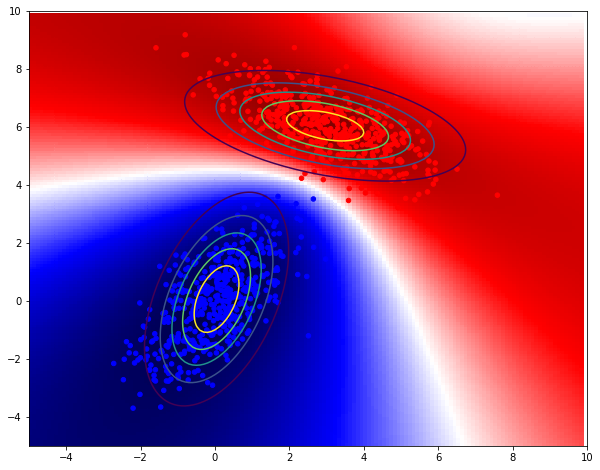

In [8]:
plotHeat(posterior)

## Constrained model

**Question 3 [5 credits]**
Now, let's look at a constrained model. How would you compute the means and covariances of the two classes, if you want to enforce that the covariances of the two classes are identical? Implement your answer, and plot the discriminant. What is the performance on the test set?

* Answer to Q3 *


In [9]:
# Q3
def cov_lin(classes):
    x_0 = np.array([point[0] for point in classes[0]])
    y_0 = np.array([point[1] for point in classes[0]])
    x_1 = np.array([point[0] for point in classes[1]])
    y_1 = np.array([point[1] for point in classes[1]])
    mu_0_x = np.mean(x_0)
    mu_0_y = np.mean(y_0)
    mu_1_x = np.mean(x_1)
    mu_1_y = np.mean(y_1)
    cov = np.multiply(np.concatenate((x_0-mu_0_x, x_1-mu_1_x), axis=0), np.concatenate((y_0-mu_0_y, y_1-mu_1_y), axis=0))
    cov = sum(cov) / len(cov)
    var_x = np.multiply(np.concatenate((x_0-mu_0_x, x_1-mu_1_x), axis=0), np.concatenate((x_0-mu_0_x, x_1-mu_1_x), axis=0))
    var_y = np.multiply(np.concatenate((y_0-mu_0_y, y_1-mu_1_y), axis=0), np.concatenate((y_0-mu_0_y, y_1-mu_1_y), axis=0))
    var_x = sum(var_x) / len(var_x)
    var_y = sum(var_y) / len(var_y)
    return np.array([[var_x, cov], [cov, var_y]])

cov_1 = cov_2 = cov_lin(classes)
#print cov_1

def posterior_lin(x,y):
    return posterior(x,y)

#print np.cov(classes[0], classes[1], rowvar = 0)

In [10]:
def test_performance(data, labels, f):
    correct = 0
    wrong = 0
    for d, l in zip(data, labels):
        if f(d[0], d[1]) > 0.5:
            if l == 0:
                correct = correct + 1
            else:
                wrong = wrong + 1
        else:
            if l == 1:
                correct = correct + 1
            else:
                wrong = wrong + 1
    return float(correct) / (correct + wrong)

In [11]:
print(test_performance(d_train, l_train, posterior_lin))

0.36875


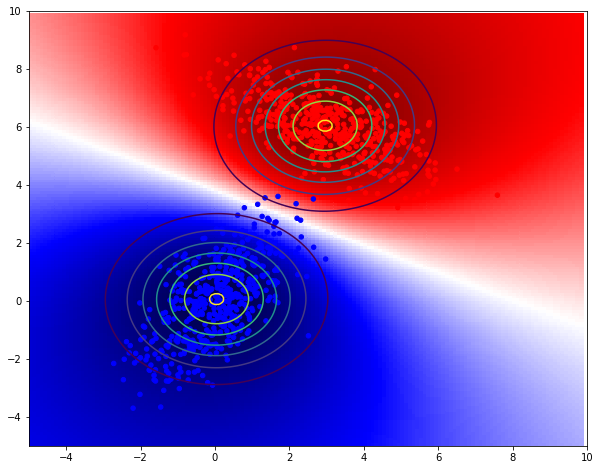

In [12]:
plotHeat(posterior_lin)

**Question 4 [5 credits]**
Let us enforce a different type of constraint. The covariances of both distributions are now not identical, but each covariance is diagonal (that is, the matrix contains only variances, not co-variances). Implement this and plot the distributions overlaid on the dataset. What is the performance on the test set? What does the discriminant look like?

In [13]:
# Q4
# discriminant = only variances multiplied
cov_1 = cov_2 = cov_lin(classes)
cov_1[1,0] = cov_1[0,1] = cov_2[1,0] = cov_2[0,1] = 0
print cov_1
def posterior_diag(x,y):
    return posterior(x, y)

print(test_performance(d_train, l_train, posterior_diag))

[[ 1.51208284  0.        ]
 [ 0.          1.49084067]]
0.36625


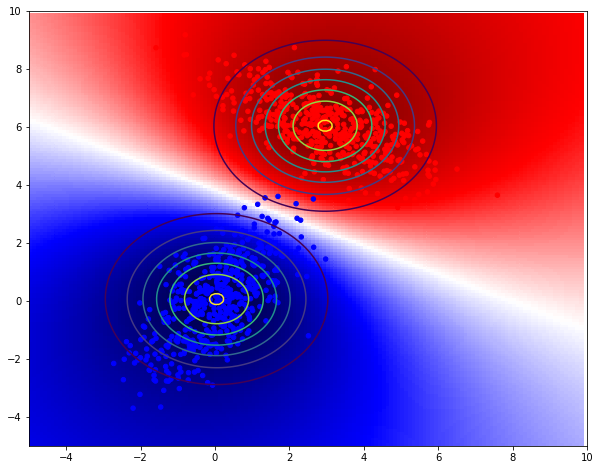

In [14]:
plotHeat(posterior_diag)

**Question 5 [5 credits]**
Finally, implement and test the model where you enforce spherical covariances. That is, there are no covariance terms in the matrix, and the variances are the same along all dimensions. Plot the distributions, the discriminant and compute the performance on the test set.

In [15]:
# Answer to Q5
def spherical_cov(data, labels):
    mus = [mu_1, mu_2]
    diffs = [d - mus[int(l)] for d, l in zip(data, labels)]
    var = sum([d[0]**2 for d in diffs] + [d[1]**2 for d in diffs]) / (len(diffs)*2)
    return np.array([[var,0],[0,var]])

cov_1 = cov_2 = spherical_cov(d_train, l_train)
print cov_1

def posterior_spherical(x,y):
    return posterior(x,y)

print(test_performance(d_train, l_train, posterior_spherical))

[[ 1.50146176  0.        ]
 [ 0.          1.50146176]]
0.36625


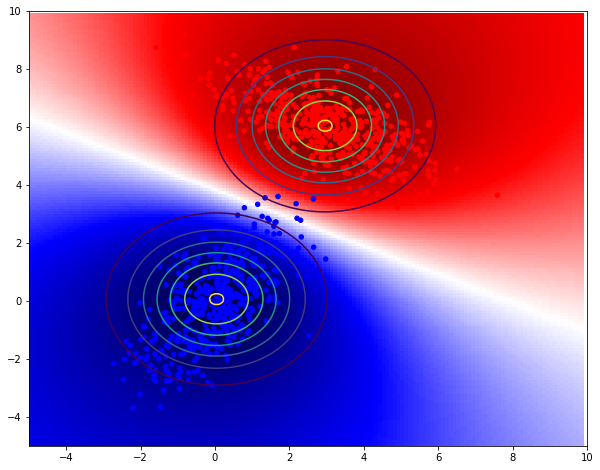

In [16]:
plotHeat(posterior_spherical)